## Please provide your inputs as followed:

- **input_sdate**: The start date of your period of interest in the format **dd-mm-YYYY**
- **input_edate**: The end date of your period of interestin the format **dd-mm-YYYY**
- **geometry**: The region of interest. Please provide this in a **bounding box format** (e.g. [10, -5, 25, 20])

In [62]:
start_date = "2023 08 20"
end_date = "2023 08 25"
bbox = [112.70505, -44.52755, 154.38241, -11.29524]
country = ""

## Library imports 

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import fsspec
import numpy as np
import xarray as xr
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time

## Starting up PySTAC client

In [64]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## User Input

### Processing of user input

In [65]:
# Function to convert date format 
def convert_format_date(input_date):
    correct_formats = ["%d %m %Y", "%Y %m %d", "%d/%m/%Y", "%Y/%m/%d", "%d-%m-%Y", "%Y-%m-%d"]
    
    for format_str in correct_formats:
        try:
            date_obj = datetime.strptime(input_date, format_str)
            formatted_date = date_obj.strftime("%Y-%m-%d")
            return formatted_date
        except ValueError: # Raised if input format is not compatible with set standard 
            pass
    
    raise ValueError("Invalid data format")

# Convert user start date format
try:
    start_date = convert_format_date(start_date)
except ValueError:
    print("Invalid start date format. Please check the acceptable formats")
            
# Convert user end date format
try:
    end_date = convert_format_date(end_date)
except ValueError:
    print("Invalid end date format. Please check the acceptable formats")

date_period = start_date + "/" + end_date 
print(date_period)


2023-08-20/2023-08-25


## Search for product

In [66]:
search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    bbox=bbox,
    datetime=date_period,
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = search.item_collection()

print(len(items))

20


## Process queried data into a dataset

In [67]:
item_links = [item.assets['ch4'].href for item in items]
item_links

f = fsspec.open_files(item_links)
f = [file.open() for file in f]


In [77]:
ds = xr.open_mfdataset(f, group="PRODUCT", engine="h5netcdf", combine='by_coords') 
ds

<xarray.Dataset>
Dimensions:                              (scanline: 4173, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 6)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-08-20 ......
    latitude                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    longitude                            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
Data variables:
    delta_time                           (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4173), meta=np.ndarray>
    time_utc                             (time, scanline) object dask.array<chunksize=(1, 4173), meta=np.ndarray>
    qa_value                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>

In [83]:
varname = "methane_mixing_ratio_bias_corrected"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])

# methane product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
methane = ds[varname].values.squeeze()

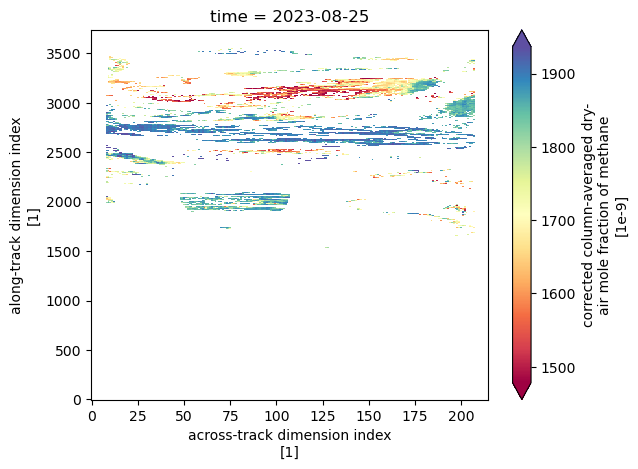

In [84]:
varname = "methane_mixing_ratio_bias_corrected"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="Spectral")

# methane product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
methane = data.values

In [85]:
methane.shape

(3735, 215)

## Plot Base Map & Concentration

/tmp/ipykernel_392/869508816.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset


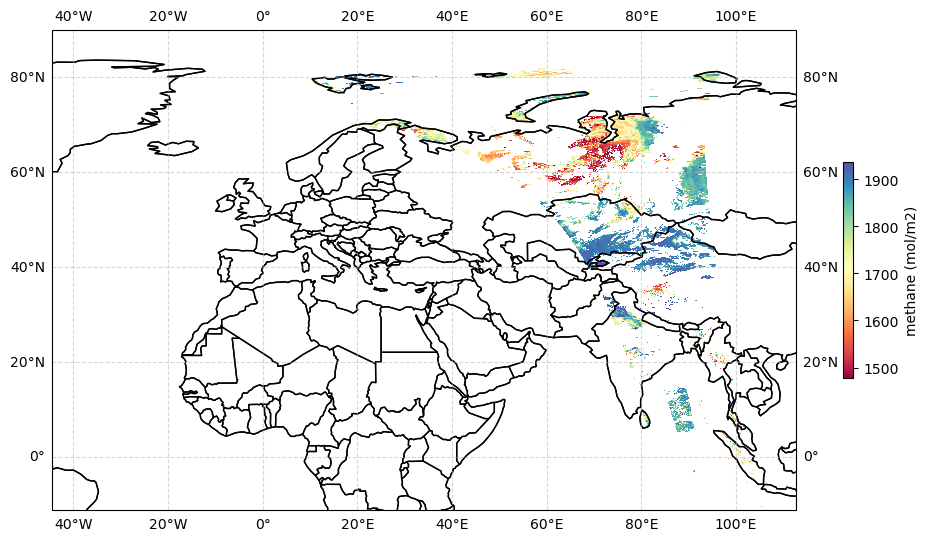

In [86]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Get geopandas in-built naturalearth_lowres dataset
continent_borders = world.dissolve(by='continent')

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

if country != "":  
    specific_country = world[world['name'].str.strip() == country] 
    
    if not specific_country.empty:
        
        specific_country.boundary.plot(ax=ax, linewidth=2, color='black')
        
      
        plt.title(f"Map Highlighting {country}")
        
        
        ax.set_xlim(specific_country.total_bounds[0], specific_country.total_bounds[2])
        ax.set_ylim(specific_country.total_bounds[1], specific_country.total_bounds[3])
    else:
        print(f"Country '{country}' not found in the dataset.")
        world.boundary.plot(ax=ax, linewidth=1, color='black')
        plt.title("World Map")
else:
    world.boundary.plot(ax=ax, linewidth=1, color='black')
    plt.title("World Map")

    
ax.set_title("")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent(bbox, crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
colormesh = ax.pcolormesh (lon, lat, methane, cmap = "Spectral", norm = norm)
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")
plt.show()

## Plot Time Series

In [75]:
ds[]

<xarray.Dataset>
Dimensions:                              (scanline: 3735, ground_pixel: 215,
                                          time: 1, corner: 4, layer: 12,
                                          level: 13)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 3.734e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * time                                 (time) datetime64[ns] 2023-08-25
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
    latitude                             (time, scanline, ground_pixel) float32 ...
    longitude                            (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                           (time, scanline) datetime64[ns] ...
    time_utc                             (time, scanline) object ...
    qa_value                             (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 ...

In [ ]:
dsf = xr.open_mfdataset(f, group="PRODUCT", engine="h5netcdf", concat_dim="time", combine='nested') 
dsf